In [1]:
# import libraries
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import numpy as np
from scipy.stats.mstats import winsorize
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import warnings
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFECV
import xgboost as xgb
from sklearn.metrics import classification_report, roc_curve, confusion_matrix
from sklearn.preprocessing import label_binarize
warnings.filterwarnings('ignore')

In [2]:
# Load data from files exported by queries
games_all = pd.read_excel('greece_games.xlsx')
# Profit calculation
games_all['PROFIT'] = games_all['REVENUE'] - games_all['COST']
# Choose only september 2021 data
games = games_all.loc[games_all['DATASET'] == 'TRAIN']
games['GAME_DATE'] = pd.to_datetime(games['GAME_DATE'], format='%Y%m%d')
users = pd.read_excel('studied_users.xlsx')

In [3]:
# Check data
games.head()
users.head()

,AGE,ZIPCODE,SEX,TENURE,REGISTRATION_DATE,USERPROFILEID,PAYPAL,RAPIDTRANSFER,DIASMYBANK,TRUSTLY,...,SKRILL,MONEYSAFE,VISACARD,MONEYBOOKERS,DIASDTM,ENVOY,NETELLER,SKRILL1TAP,AVG_DEPOSIT_AMOUNT,AVG_WITHDRAWAL_AMOUNT
0,51,85200,F,191,2021-10-04,1548945,0.0,0.0,0.0,0.0,...,0.0,0.0,19.0,0.0,0.0,0.0,0.0,0.0,800.00,0.00
1,53,66100,M,216,2021-09-09,1527981,0.0,0.0,0.0,0.0,...,0.0,0.0,47.0,0.0,0.0,0.0,0.0,0.0,1532.47,753.25
2,54,18541,F,194,2021-10-01,1546531,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,596.63,791.67
3,25,712 02,M,194,2021-10-01,1546382,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,796.30,0.00
4,63,73134,M,201,2021-09-24,1540396,0.0,0.0,0.0,0.0,...,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,800.00,2300.00


In [4]:
# Basis statistics
games.describe().T
users.describe().T

,count,mean,std,min,25%,50%,75%,max
AGE,1574.0,3.514168e+01,11.816068,22.0,2.500000e+01,32.00,4.375000e+01,81.00
TENURE,1574.0,2.064422e+02,25.171405,164.0,1.860000e+02,205.50,2.270000e+02,255.00
USERPROFILEID,1574.0,1.537276e+06,19486.924062,1503909.0,1.520962e+06,1536845.00,1.553031e+06,1574252.00
PAYPAL,1246.0,2.648475e-01,2.837868,0.0,0.000000e+00,0.00,0.000000e+00,67.00
RAPIDTRANSFER,1246.0,0.000000e+00,0.000000,0.0,0.000000e+00,0.00,0.000000e+00,0.00
DIASMYBANK,1246.0,3.105939e-01,3.375175,0.0,0.000000e+00,0.00,0.000000e+00,71.00
TRUSTLY,1246.0,0.000000e+00,0.000000,0.0,0.000000e+00,0.00,0.000000e+00,0.00
PSCPAYSAFECARD,1246.0,4.697432e+00,13.694396,0.0,0.000000e+00,0.00,2.000000e+00,184.00
VIVAWALLET,1246.0,0.000000e+00,0.000000,0.0,0.000000e+00,0.00,0.000000e+00,0.00
SKRILL,1246.0,1.364366e-02,0.354849,0.0,0.000000e+00,0.00,0.000000e+00,11.00


In [5]:
# Check null existence by column
games.isnull().sum()
users.isnull().sum()

AGE                        0
ZIPCODE                    0
SEX                        0
TENURE                     0
REGISTRATION_DATE          0
USERPROFILEID              0
PAYPAL                   328
RAPIDTRANSFER            328
DIASMYBANK               328
TRUSTLY                  328
PSCPAYSAFECARD           328
VIVAWALLET               328
SKRILL                   328
MONEYSAFE                328
VISACARD                 328
MONEYBOOKERS             328
DIASDTM                  328
ENVOY                    328
NETELLER                 328
SKRILL1TAP               328
AVG_DEPOSIT_AMOUNT       316
AVG_WITHDRAWAL_AMOUNT    316
dtype: int64

In [6]:
# Fill nulls with zero value
users.fillna(0, inplace=True)

# Data Exploration

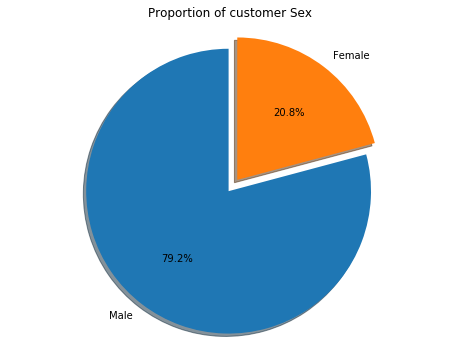

In [7]:
# Sex ratio in customer base
labels = 'Male', 'Female'
sizes = [users.SEX[users['SEX']=='M'].count(), users.SEX[users['SEX']=='F'].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(8, 6))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of customer Sex")
plt.show()

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

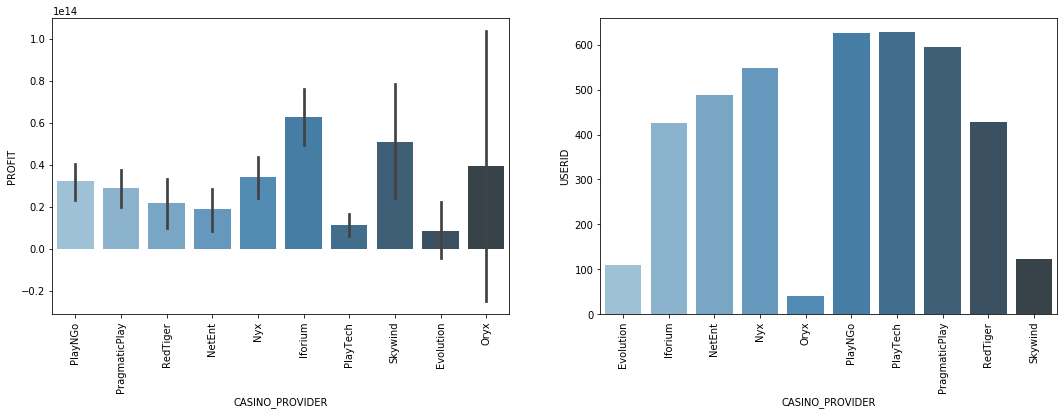

In [8]:
# Iforium provider seems to bring in most profit
# Although Oryx does not have many users (popularity) people spend there significant amount of money
plt.figure(figsize=(18,12))
plt.subplot(2,2,1)
sns.barplot(x="CASINO_PROVIDER", y="PROFIT", data=games, palette="Blues_d")
plt.xticks(rotation=90)

plt.subplot(2,2,2)
popularity = pd.DataFrame(games.groupby('CASINO_PROVIDER')['USERID'].nunique().reset_index())
ax = sns.barplot(x="CASINO_PROVIDER", y="USERID", data=popularity, palette="Blues_d")
plt.xticks(rotation=90)

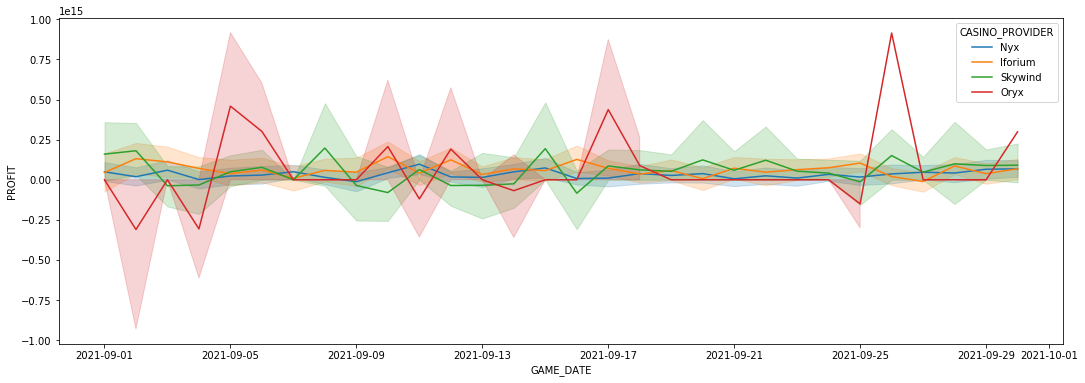

In [9]:
# There seem to be some seasonality that drives Oryx, perhaps spesific promos
plt.figure(figsize=(18,6))
sns.lineplot(data=games.loc[games['CASINO_PROVIDER'].isin(['Oryx', 'Skywind', 'Iforium', 'Nyx'])], x="GAME_DATE", y="PROFIT", hue="CASINO_PROVIDER")

In [10]:
# Check for outliers using winsor method and trim existent

numerical_features = ['REVENUE', 'COST', 'PROFIT']
lst = list(games[numerical_features])

length = len(games)
for col in lst:
    q75, q25 = np.percentile(games[col], [75 ,25])
    iqr = q75 - q25

    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    print("Number of outliers and percentage of it in {} : {} and %{}".format(col, len((np.where((games[col] > max_val) |
                                                                                        (games[col] < min_val))[0])), len((np.where((games[col] > max_val) |
                                                                                                                                     (games[col] < min_val))[0]))*100/length)) 
    print('percent of outliers low')
    print(len(np.where(games[col] < min_val)[0]) /length)
    print('Percent of outliers high')
    print(len(np.where(games[col] > max_val)[0]) /length)
    print(90 * '-')
    
        
length = len(games)
for col in lst:
    q75, q25 = np.percentile(games[col], [75, 25])
    iqr = q75 - q25

    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)

    games[col] = winsorize(games[col], (len(np.where(games[col] <= min_val)[0]) / length,
                                  len(np.where(games[col] >= max_val)[0]) / length
                                  )
                        )

Number of outliers and percentage of it in REVENUE : 4026 and %20.620774431468963
percent of outliers low
0.0
Percent of outliers high
0.2062077443146896
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in COST : 3559 and %18.228846547838558
percent of outliers low
0.0
Percent of outliers high
0.18228846547838556
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in PROFIT : 6071 and %31.095062487195246
percent of outliers low
0.10602335586969883
Percent of outliers high
0.20492726900225364
------------------------------------------------------------------------------------------


In [11]:
# We are going to create segments of customers using the RFM method
# R => Recency: How many days where they inactive
# F => Frequency: How many times they played
# M => Monetary: Revenue brought in

#create a generic user dataframe to keep CustomerID and new segmentation scores
game_users = pd.DataFrame(games['USERID'].unique())
game_users.columns = ['USERID']

#get the max purchase date for each customer and create a dataframe with it
max_transactions = games.groupby('USERID').GAME_DATE.max().reset_index()
max_transactions.columns = ['USERID','MAX_TRANSACTION_DATE']

#we take our observation point as the max invoice date in our dataset
max_transactions['RECENCY'] = (max_transactions['MAX_TRANSACTION_DATE'].max() - max_transactions['MAX_TRANSACTION_DATE']).dt.days

#merge this dataframe to our new user dataframe
game_users = pd.merge(game_users, max_transactions[['USERID','RECENCY']], on='USERID')

game_users.head()

,USERID,RECENCY
0,1503973,0
1,1504107,29
2,1504618,0
3,1504807,2
4,1505560,0


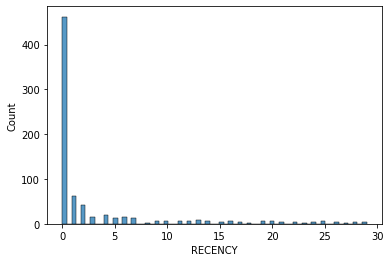

In [12]:
sns.histplot(data=game_users, x="RECENCY")

<Figure size 1080x576 with 0 Axes>

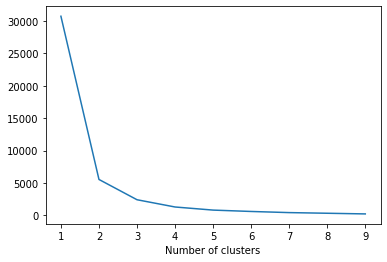

In [13]:
# Elbow method to identify optimal number of clusters
plt.figure(figsize=(15,8))

dict={}
recency = game_users[['RECENCY']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(recency)
    recency["clusters"] = kmeans.labels_
    dict[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(dict.keys()), list(dict.values()))
plt.xlabel("Number of clusters")
plt.show()

In [14]:
#build 3 clusters for recency and add it to dataframe
kmeans = KMeans(n_clusters=3)
kmeans.fit(game_users[['RECENCY']])
game_users['RECENCY_CLUSTER'] = kmeans.predict(game_users[['RECENCY']])

#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    
    return df_final

game_users = order_cluster('RECENCY_CLUSTER', 'RECENCY',game_users,False)

In [15]:
#get order counts for each user and create a dataframe with it
frequency = games.groupby('USERID').GAME_DATE.count().reset_index()
frequency.columns = ['USERID','FREQUENCY']

#add this data to our main dataframe
game_users = pd.merge(game_users, frequency, on='USERID')
game_users.head()

,USERID,RECENCY,RECENCY_CLUSTER,FREQUENCY
0,1503973,0,2,26
1,1504618,0,2,110
2,1504807,2,2,42
3,1505560,0,2,26
4,1505571,0,2,24


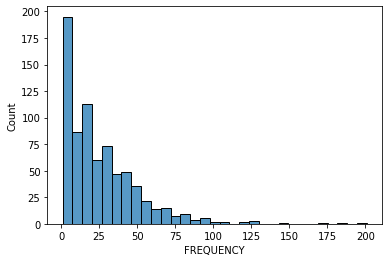

In [16]:
sns.histplot(data=game_users, x="FREQUENCY")

<Figure size 1080x576 with 0 Axes>

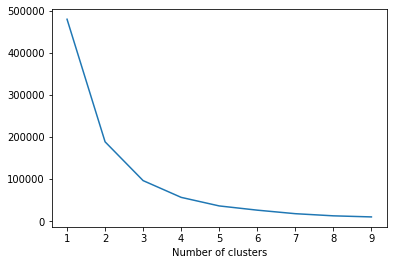

In [17]:
# Elbow method to identify optimal number of clusters
plt.figure(figsize=(15,8))

dict={}
frequency = game_users[['FREQUENCY']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(frequency)
    frequency["clusters"] = kmeans.labels_
    dict[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(dict.keys()), list(dict.values()))
plt.xlabel("Number of clusters")
plt.show()

In [18]:
#k-means
kmeans = KMeans(n_clusters=3)
kmeans.fit(game_users[['FREQUENCY']])
game_users['FREQUENCY_CLUSTER'] = kmeans.predict(game_users[['FREQUENCY']])

#order the frequency cluster
game_users = order_cluster('FREQUENCY_CLUSTER', 'FREQUENCY',game_users,True)

In [19]:
#calculate revenue for each customer
revenue = games.groupby('USERID').REVENUE.sum().reset_index()

#merge it with our main dataframe
game_users = pd.merge(game_users, revenue, on='USERID')
game_users.head()

,USERID,RECENCY,RECENCY_CLUSTER,FREQUENCY,FREQUENCY_CLUSTER,REVENUE
0,1503973,0,2,26,0,28350
1,1505560,0,2,26,0,58134
2,1505571,0,2,24,0,12383
3,1508030,0,2,20,0,5832
4,1510159,0,2,16,0,88391


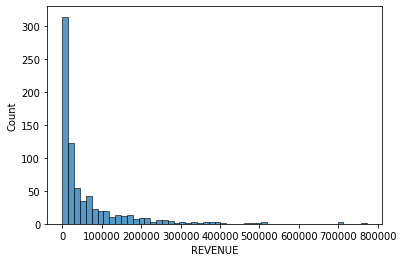

In [20]:
sns.histplot(data=game_users, x="REVENUE")

<Figure size 1080x576 with 0 Axes>

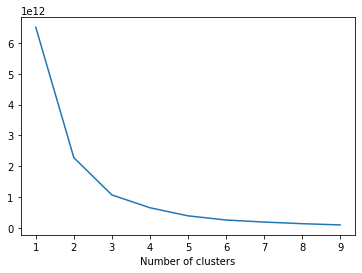

In [21]:
# Elbow method to identify optimal number of clusters
plt.figure(figsize=(15,8))

dict={}
revenue = game_users[['REVENUE']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(revenue)
    revenue["clusters"] = kmeans.labels_
    dict[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(dict.keys()), list(dict.values()))
plt.xlabel("Number of clusters")
plt.show()

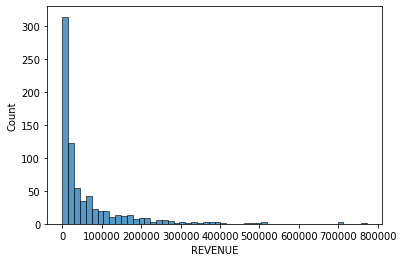

In [22]:
sns.histplot(data=game_users, x="REVENUE")

#apply clustering
kmeans = KMeans(n_clusters=3)
kmeans.fit(game_users[['REVENUE']])
game_users['REVENUE_CLUSTER'] = kmeans.predict(game_users[['REVENUE']])


#order the cluster numbers
game_users = order_cluster('REVENUE_CLUSTER', 'REVENUE',game_users,True)

In [23]:
#calculate overall score and use mean() to see details
game_users['OVERALL_SCORE'] = game_users['RECENCY_CLUSTER'] + game_users['FREQUENCY_CLUSTER'] + game_users['REVENUE_CLUSTER']
game_users.groupby('OVERALL_SCORE')['RECENCY','FREQUENCY','REVENUE'].mean()

,RECENCY,FREQUENCY,REVENUE
OVERALL_SCORE,,,
0,22.214286,5.857143,13452.839286
1,9.294872,8.948718,17904.051282
2,0.852665,12.614420,19196.498433
3,0.470968,37.529032,42955.929032
4,0.360000,48.160000,159366.110000
5,0.130435,85.956522,239160.434783
6,0.000000,116.500000,475149.125000


In [24]:
# Assign segment name based on user value to the company
game_users['SEGMENT'] = 'Low'
game_users.loc[game_users['OVERALL_SCORE']>2,'SEGMENT'] = 'Mid' 
game_users.loc[game_users['OVERALL_SCORE']>5,'SEGMENT'] = 'High' 

In [25]:
# Merge with dataframe containing rest characteristics
joined_df = pd.merge(game_users, users, left_on='USERID', right_on = 'USERPROFILEID', how = 'inner')

# Results Exploration

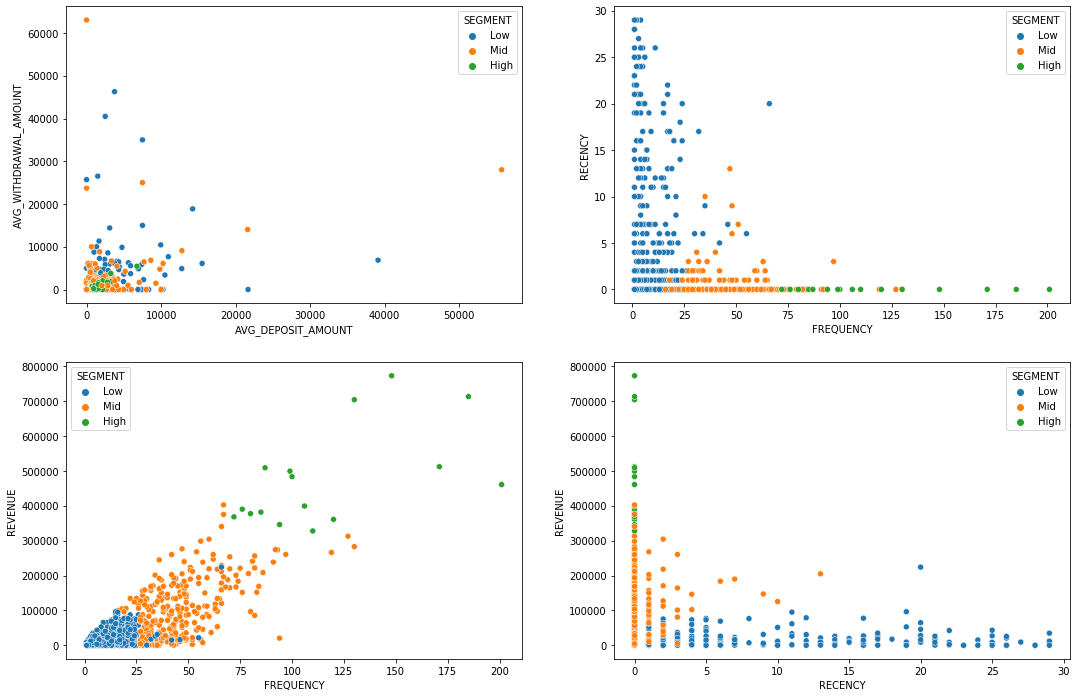

In [26]:
# As anticipated, high value customers play more frequently, bring more revenue, and have less inactivity days
plt.figure(figsize=(18,12))
plt.subplot(2,2,1)
sns.scatterplot(data=joined_df, x="AVG_DEPOSIT_AMOUNT", y="AVG_WITHDRAWAL_AMOUNT", hue="SEGMENT")
plt.subplot(2,2,2)
sns.scatterplot(data=joined_df, x="FREQUENCY", y="RECENCY", hue="SEGMENT")
plt.subplot(2,2,3)
sns.scatterplot(data=joined_df, x="FREQUENCY", y="REVENUE", hue="SEGMENT")
plt.subplot(2,2,4)
sns.scatterplot(data=joined_df, x="RECENCY", y="REVENUE", hue="SEGMENT")

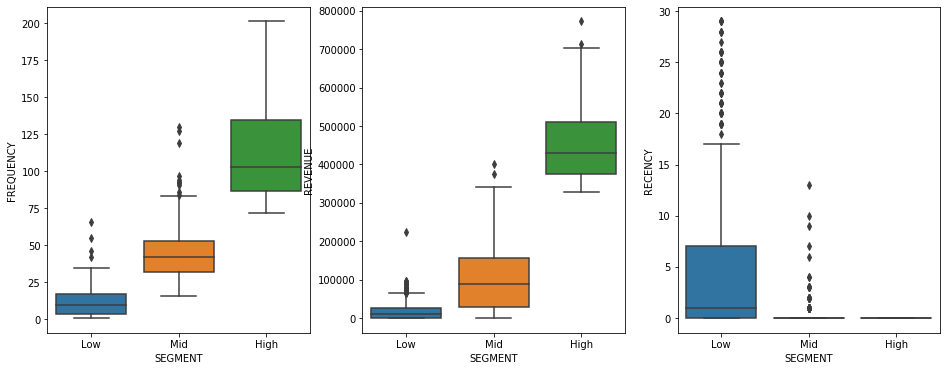

In [27]:
# High value customers seem to be longer with the company and older than rest of customer base
plt.figure(figsize=(16,6))
plt.subplot(1,3,1)
sns.boxplot( x=joined_df["SEGMENT"], y=joined_df["FREQUENCY"] )
plt.subplot(1,3,2)
sns.boxplot( x=joined_df["SEGMENT"], y=joined_df["REVENUE"] )
plt.subplot(1,3,3)
sns.boxplot( x=joined_df["SEGMENT"], y=joined_df["RECENCY"] )

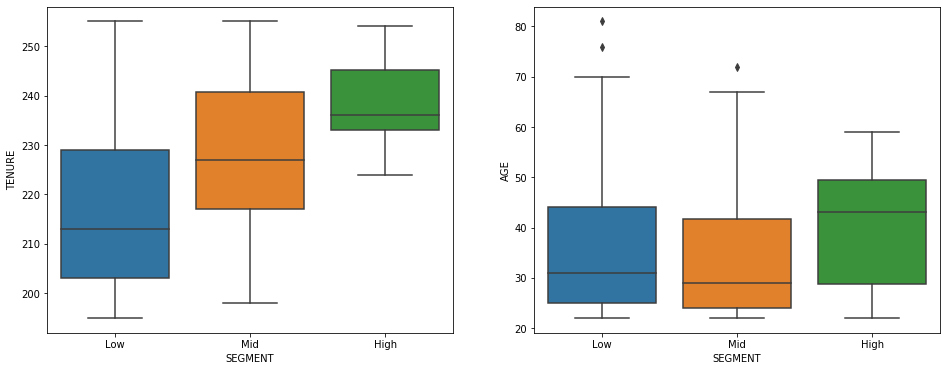

In [28]:
# High value customers seem to be longer with the company and older than rest of customer base
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
sns.boxplot( x=joined_df["SEGMENT"], y=joined_df["TENURE"] )
plt.subplot(1,2,2)
sns.boxplot( x=joined_df["SEGMENT"], y=joined_df["AGE"] )

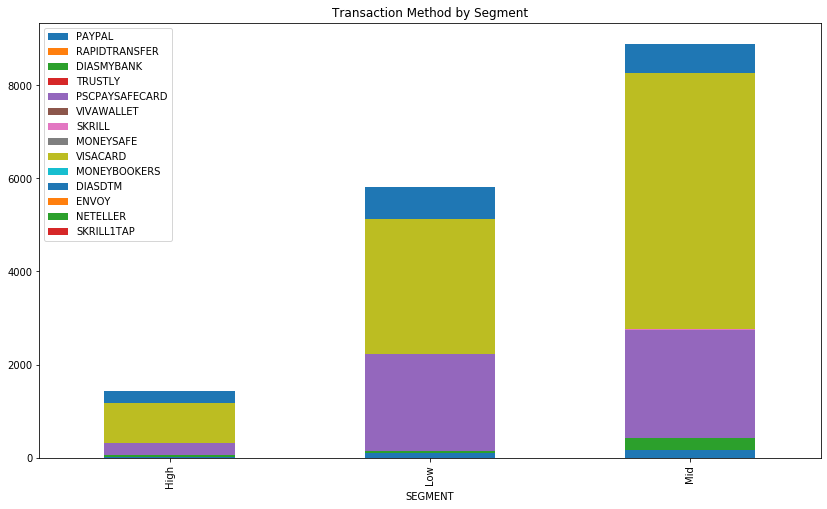

In [29]:
# No significant differentation seems to be present on the transaction method 
payment_method = joined_df[['SEGMENT', 'PAYPAL', 'RAPIDTRANSFER', 'DIASMYBANK', 'TRUSTLY',
                           'PSCPAYSAFECARD', 'VIVAWALLET', 'SKRILL', 'MONEYSAFE', 'VISACARD',
                           'MONEYBOOKERS', 'DIASDTM', 'ENVOY', 'NETELLER', 'SKRILL1TAP']]

payment_method = payment_method.groupby('SEGMENT', as_index=False).sum()
# plot data in stack manner of bar type
plt.rcParams["figure.figsize"] = (14, 8)
payment_method.plot(x='SEGMENT', kind='bar', stacked=True, title='Transaction Method by Segment')

In [30]:
# Calculate a new dataframe for October
oct_games = games_all.loc[games_all['DATASET'] == 'TEST']
oct_games_users = oct_games.groupby('USERID')['PROFIT'].sum().reset_index()
oct_games_users.columns = ['USERID','OCT_PROFIT']

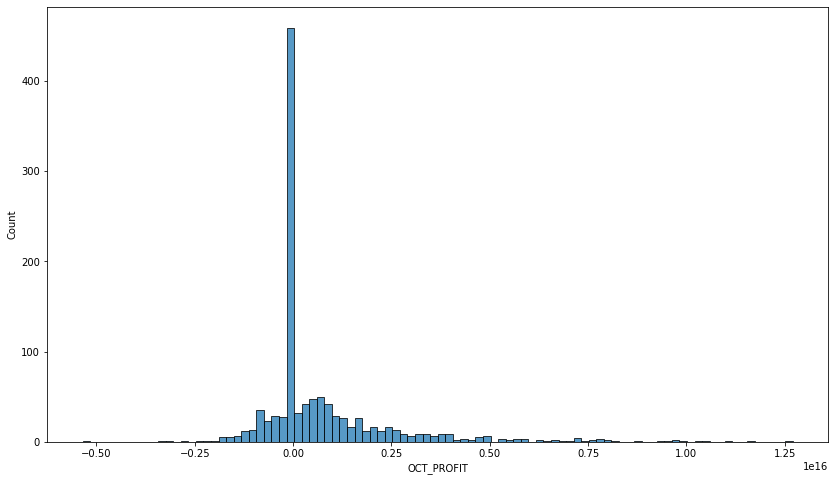

In [31]:
sns.histplot(data=oct_games_users, x="OCT_PROFIT")

In [32]:
# Trim outliers

numerical_features = ['OCT_PROFIT']
lst = list(oct_games_users[numerical_features])

length = len(oct_games_users)
for col in lst:
    q75, q25 = np.percentile(oct_games_users[col], [75, 25])
    iqr = q75 - q25

    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)

    oct_games_users[col] = winsorize(oct_games_users[col], (len(np.where(oct_games_users[col] <= min_val)[0]) / length,
                                  len(np.where(oct_games_users[col] >= max_val)[0]) / length
                                  )
                        )

In [33]:
games_merged = pd.merge(game_users, oct_games_users, on='USERID', how='left')
games_merged = games_merged.fillna(0)

In [34]:
#creating 3 clusters
kmeans = KMeans(n_clusters=3)
kmeans.fit(games_merged[['OCT_PROFIT']])
games_merged['LTV_Cluster'] = kmeans.predict(games_merged[['OCT_PROFIT']])

#order cluster number based on LTV
games_merged = order_cluster('LTV_Cluster', 'OCT_PROFIT',games_merged,True)

#creatinga new cluster dataframe
new_cluster = games_merged.copy()

#see details of the clusters
new_cluster.groupby('LTV_Cluster')['OCT_PROFIT'].describe()

,count,mean,std,min,25%,50%,75%,max
LTV_Cluster,,,,,,,,
0,88.0,-8.709034e+14,3.392007e+14,-1.495900e+15,-1.118375e+15,-8.145000e+14,-6.212500e+14,-3.568320e+14
1,494.0,1.700734e+14,3.322425e+14,-3.105000e+14,-6.479250e+03,0.000000e+00,2.671600e+14,1.192380e+15
2,165.0,2.231795e+15,3.969781e+14,1.217900e+15,2.016300e+15,2.487877e+15,2.487877e+15,2.487877e+15


In [35]:
new_cluster = pd.merge(new_cluster, users[['USERPROFILEID', 'TENURE', 'AGE']], left_on='USERID', right_on='USERPROFILEID', how = 'left')

In [36]:
#convert categorical columns to numerical
new_cluster = pd.get_dummies(new_cluster) 
new_cluster = new_cluster.set_index('USERID')
new_cluster = new_cluster.drop(columns='USERPROFILEID', axis=1)
new_cluster.head()

,RECENCY,RECENCY_CLUSTER,FREQUENCY,FREQUENCY_CLUSTER,REVENUE,REVENUE_CLUSTER,OVERALL_SCORE,OCT_PROFIT,LTV_Cluster,TENURE,AGE,SEGMENT_High,SEGMENT_Low,SEGMENT_Mid
USERID,,,,,,,,,,,,,,
1503973,0,2,26,0,28350,0,2,1.293600e+15,2,255,23,0,1,0
1510159,0,2,16,0,88391,0,2,2.438080e+15,2,244,26,0,1,0
1531671,0,2,7,0,25023,0,2,2.016300e+15,2,211,49,0,1,0
1542057,0,2,15,0,31388,0,2,2.183125e+15,2,199,27,0,1,0
1510906,0,2,15,0,34764,0,2,1.605040e+15,2,242,47,0,1,0


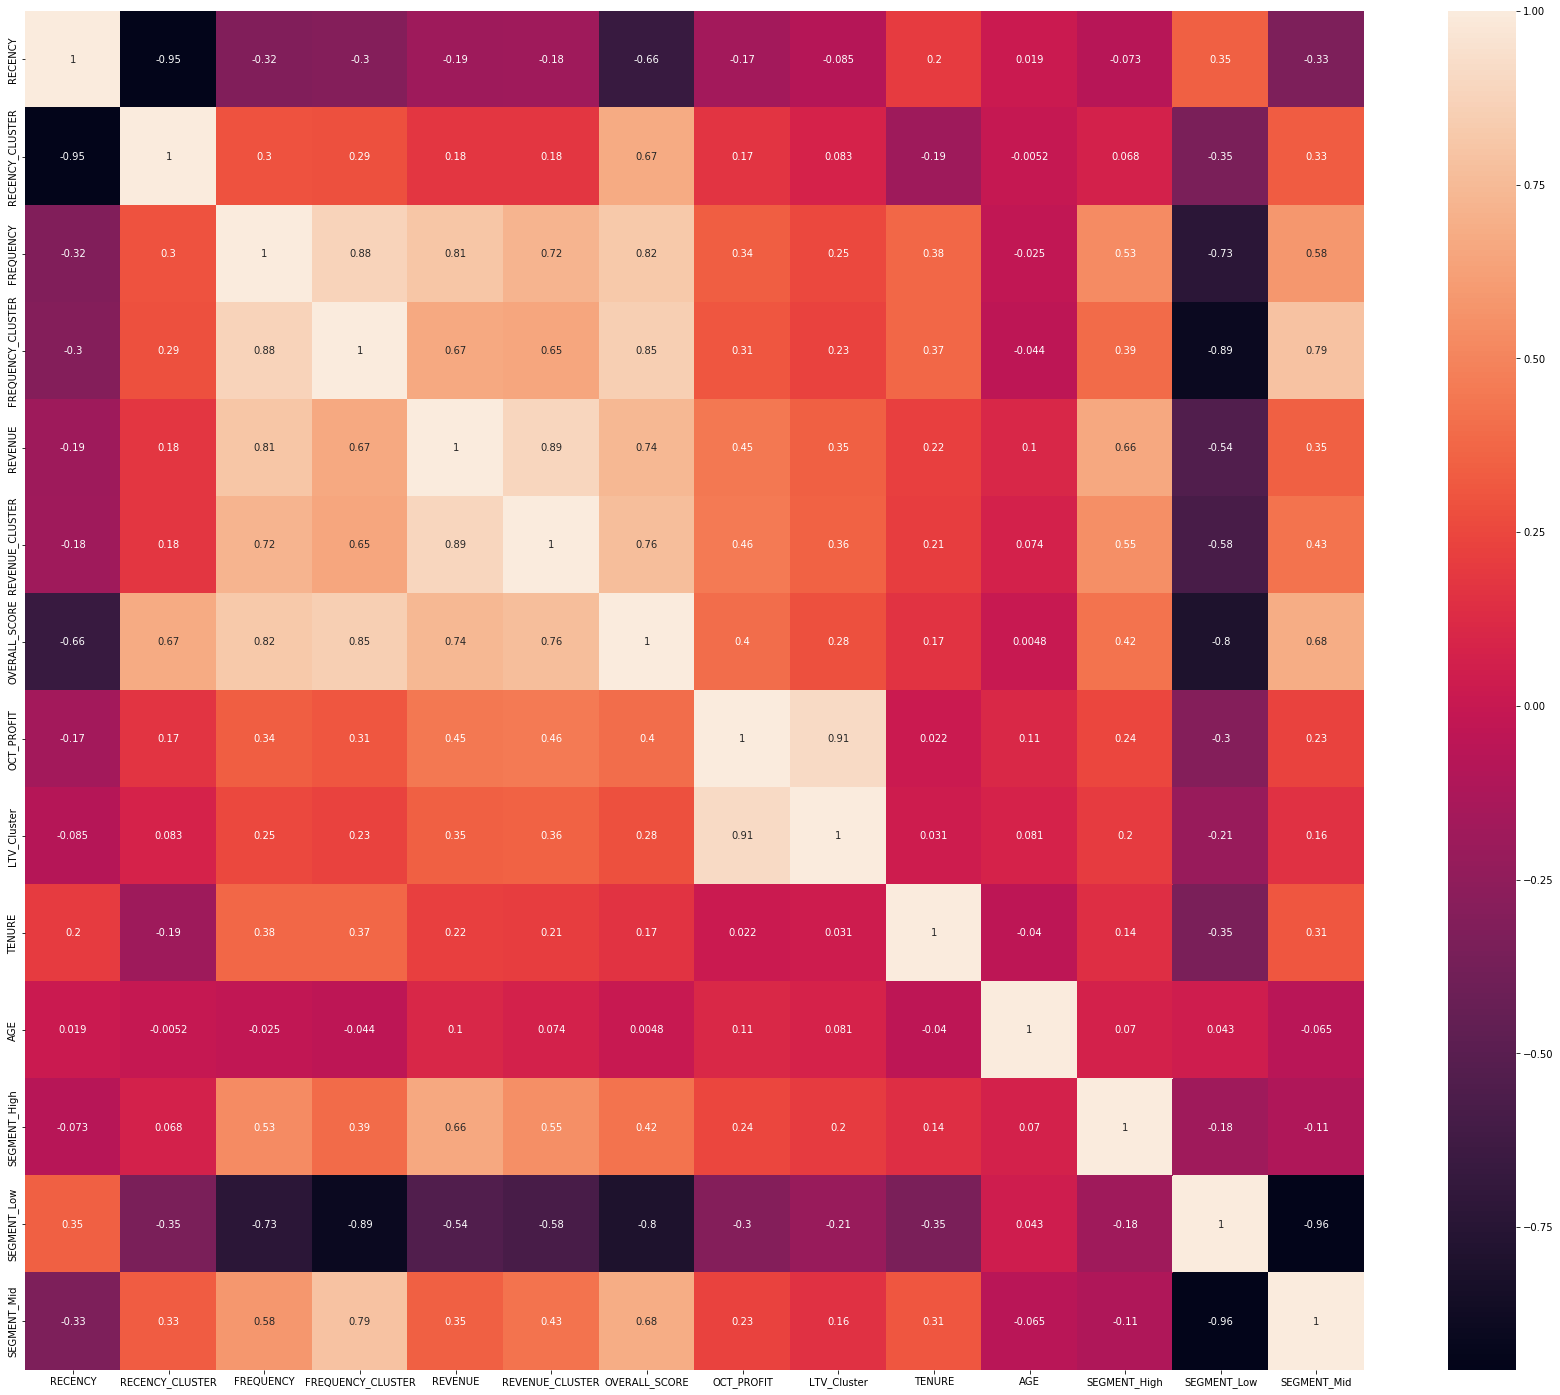

In [37]:
# There seems to be some corellated features in the data

plt.figure(figsize = (30, 25))
sns.heatmap(new_cluster.corr(), annot = True)
plt.show()

In [38]:
# X -> Predictors, y -> Target 
y = new_cluster['LTV_Cluster']
X = new_cluster.drop(['LTV_Cluster','OCT_PROFIT'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [39]:
# Try an xgboost model
import xgboost as xgb

xgb  = xgb.XGBClassifier(max_depth = 5, subsample = 0.7, colsample_bytree = 0.7, 
                         n_estimators = 200, early_stopping = 10, learning_rate = 0.01,
                         colsample_bylevel=0.7, silent=True, n_jobs=4, eval_metric="mlogloss", 
                         random_state=42, verbosity = 0)

# Use recursive feature elimination to test the information gain from each feature
selector = RFECV(xgb, step=1, min_features_to_select=1, cv=StratifiedKFold(5))

#Fit the model, get a rank of the variables, and a matrix of the selected X variables
selector = selector.fit(X_train, y_train.values)

#Get rank of X model features
rank = selector.ranking_

# Summarize all features
for i in range(X.shape[1]):
    print('\nColumn: %d, Selected %s, Rank: %.3f,' % (i, selector.support_[i], selector.ranking_[i]), 'Name:', X.columns[i])


Column: 0, Selected True, Rank: 1.000, Name: RECENCY

Column: 1, Selected True, Rank: 1.000, Name: RECENCY_CLUSTER

Column: 2, Selected True, Rank: 1.000, Name: FREQUENCY

Column: 3, Selected True, Rank: 1.000, Name: FREQUENCY_CLUSTER

Column: 4, Selected True, Rank: 1.000, Name: REVENUE

Column: 5, Selected True, Rank: 1.000, Name: REVENUE_CLUSTER

Column: 6, Selected True, Rank: 1.000, Name: OVERALL_SCORE

Column: 7, Selected True, Rank: 1.000, Name: TENURE

Column: 8, Selected True, Rank: 1.000, Name: AGE

Column: 9, Selected True, Rank: 1.000, Name: SEGMENT_High

Column: 10, Selected True, Rank: 1.000, Name: SEGMENT_Low

Column: 11, Selected True, Rank: 1.000, Name: SEGMENT_Mid


In [40]:
# Use only best features to make predictions
import xgboost as xgb

X_rfecv = X.iloc[:, selector.support_]
X_train, X_test, y_train, y_test = train_test_split(X_rfecv, y, test_size = 0.20, random_state = 42) 

eval_set = [(X_train, y_train), (X_test, y_test)]  


clf  = xgb.XGBClassifier(max_depth = 5, subsample = 0.7, colsample_bytree = 0.7, 
                         n_estimators = 200, early_stopping = 10, learning_rate = 0.01,
                         colsample_bylevel=0.7, silent=True, n_jobs=4, eval_metric="mlogloss", 
                         random_state=42, verbosity = 0)


clf.fit(X_train, y_train, eval_set=eval_set)

y_pred = clf.predict(X_test)

[0]	validation_0-mlogloss:1.09188	validation_1-mlogloss:1.09331
[1]	validation_0-mlogloss:1.08516	validation_1-mlogloss:1.08807
[2]	validation_0-mlogloss:1.0786	validation_1-mlogloss:1.08321
[3]	validation_0-mlogloss:1.07238	validation_1-mlogloss:1.0783
[4]	validation_0-mlogloss:1.06593	validation_1-mlogloss:1.0734
[5]	validation_0-mlogloss:1.06014	validation_1-mlogloss:1.06863
[6]	validation_0-mlogloss:1.0539	validation_1-mlogloss:1.06384
[7]	validation_0-mlogloss:1.04804	validation_1-mlogloss:1.05911
[8]	validation_0-mlogloss:1.04221	validation_1-mlogloss:1.05449
[9]	validation_0-mlogloss:1.03661	validation_1-mlogloss:1.04981
[10]	validation_0-mlogloss:1.03051	validation_1-mlogloss:1.04496
[11]	validation_0-mlogloss:1.02477	validation_1-mlogloss:1.04059
[12]	validation_0-mlogloss:1.01902	validation_1-mlogloss:1.03624
[13]	validation_0-mlogloss:1.01361	validation_1-mlogloss:1.03196
[14]	validation_0-mlogloss:1.00791	validation_1-mlogloss:1.02795
[15]	validation_0-mlogloss:1.00246	vali

[124]	validation_0-mlogloss:0.672295	validation_1-mlogloss:0.811958
[125]	validation_0-mlogloss:0.6706	validation_1-mlogloss:0.811448
[126]	validation_0-mlogloss:0.668837	validation_1-mlogloss:0.810905
[127]	validation_0-mlogloss:0.667249	validation_1-mlogloss:0.810301
[128]	validation_0-mlogloss:0.665561	validation_1-mlogloss:0.809423
[129]	validation_0-mlogloss:0.663801	validation_1-mlogloss:0.808678
[130]	validation_0-mlogloss:0.662023	validation_1-mlogloss:0.80803
[131]	validation_0-mlogloss:0.660489	validation_1-mlogloss:0.807245
[132]	validation_0-mlogloss:0.659119	validation_1-mlogloss:0.806524
[133]	validation_0-mlogloss:0.65766	validation_1-mlogloss:0.805963
[134]	validation_0-mlogloss:0.656087	validation_1-mlogloss:0.80549
[135]	validation_0-mlogloss:0.654344	validation_1-mlogloss:0.805016
[136]	validation_0-mlogloss:0.652547	validation_1-mlogloss:0.804054
[137]	validation_0-mlogloss:0.651133	validation_1-mlogloss:0.803637
[138]	validation_0-mlogloss:0.64965	validation_1-mlog

In [41]:
print('\n\nOverall Metrics\n\n', classification_report(y_test, y_pred))



Overall Metrics

               precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.73      0.94      0.82        98
           2       0.58      0.40      0.47        35

    accuracy                           0.71       150
   macro avg       0.44      0.45      0.43       150
weighted avg       0.61      0.71      0.65       150



<Figure size 2160x4320 with 0 Axes>

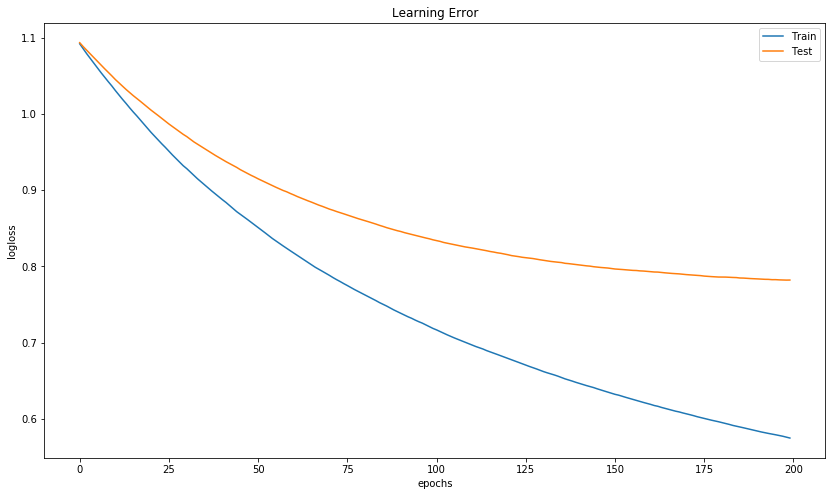

In [42]:
# Plot of training error to make sure we are not overfitting
results = clf.evals_result()
plt.figure(figsize=(30,60))
   
# retrieve performance metrics
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.xlabel('epochs')
plt.ylabel('logloss')
plt.title('Learning Error')
plt.show()

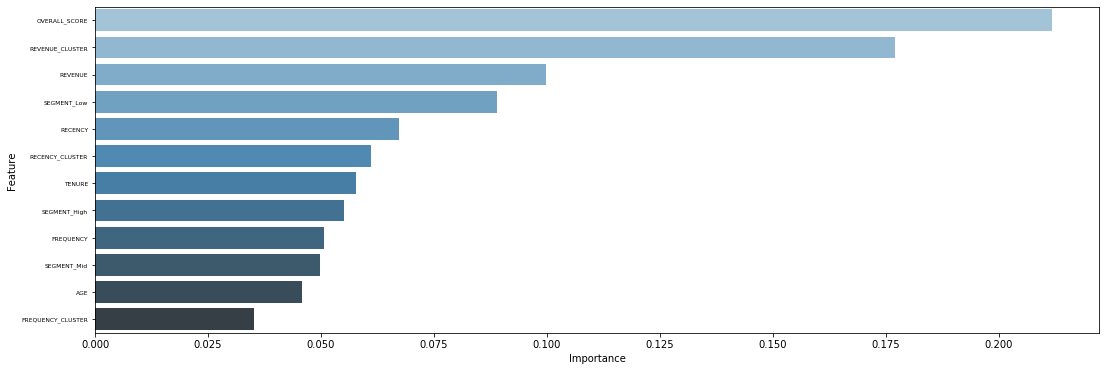

In [43]:
# Plot of most important features
importances = pd.DataFrame({
    'Feature': X_rfecv.columns,
    'Importance': clf.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances = importances.set_index('Feature')

feat_imp_plot = importances.iloc[:][:]
plt.figure(figsize=(18,6))
ax = sns.barplot(x=feat_imp_plot['Importance'], y=feat_imp_plot.index, data=feat_imp_plot, palette="Blues_d")
_, labels = plt.yticks()
# set the label size
ax.set_yticklabels(labels, size = 6)
plt.show()

In [ ]:
# Need for more data especially for the segments low and high
# Hyparameter tunning needed as well
# Further feature creation such as areas from zipcodes